In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np  #0 white 1 black 2 chinese 3 indian 4 hispanic
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import asarray 
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.transforms import ToPILImage, ToTensor
import re
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

#for dirname, _, filenames in os.walk('/kaggle/input/utkface-new/UTKFace'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))   
        
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
image_folder = "/kaggle/input/utkface-new/UTKFace"
file_names = []
ages = []
genders = []
races = []
file_id = []
image_array = []

for filename in os.listdir(image_folder):               #Iterating through filenames in the image folder
    if filename.endswith(".jpg.chip.jpg"):
        if len(list(filename.split("_"))) == 4:         
            
            im = Image.open(image_folder + '/' + filename) #Opening each Image iteratively
            #print(filename.split("_"))
            #print(len(list(filename.split("_"))))
            numpydata = asarray(im)                         #Image into ndarray
            age, gender, race, file_id = filename.split("_") 
            #print(age)
                                            #Populating storage lists
            image_array.append(numpydata)   #Images
            file_names.append(file_id)      #Id of each image file
            ages.append(age)                #Ages
            genders.append(gender)          #Genders
            races.append(race)              #Races

In [ ]:
# print(genders)
# for i in range(len(genders)) :
#     genders[i] = int(genders[i])
# print(genders)

In [3]:
#Creation of the Dataframe
data = {
    "file_name": file_names,
    "age": ages,
    "gender": genders,
    "race": races,
    "image_array": image_array,  
}

df = pd.DataFrame(data)
#print(df)
hashable_columns = ['file_name','age','gender','race']
#Searching for duplicates
duplicates = df.duplicated(subset=hashable_columns)
#Dropping duplicates
df = df.drop_duplicates(subset=hashable_columns)
df = df.reset_index()
#print(df)
#print(duplicates)

In [ ]:
#df['image_array'] = df['image_array'].apply(lambda x:torch.tensor(x))     #Image dataframe to tensors
#Age values  normalised
#df['age'] = df['age'].astype(float)
#df['age'] = (df['age'] - df['age'].min()) / (df['age'].max() - df['age'].min())


In [6]:
df.head()

,index,file_name,age,gender,race,image_array
0,0,20170104023102422.jpg.chip.jpg,26,0,2,"[[[17, 11, 11], [12, 6, 6], [9, 5, 6], [10, 6,..."
1,1,20170112233644761.jpg.chip.jpg,22,1,1,"[[[0, 4, 7], [0, 4, 7], [0, 4, 5], [0, 4, 5], ..."
2,2,20170105003215901.jpg.chip.jpg,21,1,3,"[[[41, 43, 38], [39, 41, 36], [36, 38, 33], [3..."
3,3,20170117180555824.jpg.chip.jpg,28,0,0,"[[[142, 98, 59], [143, 99, 60], [146, 102, 63]..."
4,4,20170103222931966.jpg.chip.jpg,17,1,4,"[[[127, 92, 88], [131, 96, 92], [137, 102, 98]..."


In [7]:
df.head

<bound method NDFrame.head of        index                       file_name age gender race  \
0          0  20170104023102422.jpg.chip.jpg  26      0    2   
1          1  20170112233644761.jpg.chip.jpg  22      1    1   
2          2  20170105003215901.jpg.chip.jpg  21      1    3   
3          3  20170117180555824.jpg.chip.jpg  28      0    0   
4          4  20170103222931966.jpg.chip.jpg  17      1    4   
...      ...                             ...  ..    ...  ...   
23699  23699  20170109012220690.jpg.chip.jpg  41      0    0   
23700  23700  20170117185738076.jpg.chip.jpg  42      0    0   
23701  23701  20161219221701671.jpg.chip.jpg   2      0    2   
23702  23702  20170110182002744.jpg.chip.jpg  65      1    0   
23703  23703  20170117195116702.jpg.chip.jpg  66      0    1   

                                             image_array  
0      [[[17, 11, 11], [12, 6, 6], [9, 5, 6], [10, 6,...  
1      [[[0, 4, 7], [0, 4, 7], [0, 4, 5], [0, 4, 5], ...  
2      [[[41, 43, 38], [

In [4]:
age_counts = df['age'].value_counts().sort_index()
print(age_counts)

1      1123
10      156
100      11
101       2
103       1
       ... 
92       13
93        5
95        9
96       17
99        9
Name: age, Length: 104, dtype: int64


In [8]:
age_description = df['age'].describe()
#print(age_description)
print(df['age'].unique())

['26' '22' '21' '28' '17' '44' '35' '76' '36' '34' '18' '40' '45' '70'
 '67' '12' '24' '54' '4' '46' '38' '90' '72' '2' '23' '10' '16' '31' '1'
 '27' '63' '79' '50' '41' '75' '61' '29' '82' '42' '32' '13' '14' '25'
 '15' '85' '59' '66' '30' '20' '19' '3' '65' '51' '115' '64' '43' '37'
 '58' '49' '80' '5' '57' '53' '9' '55' '56' '33' '69' '60' '86' '8' '52'
 '62' '88' '47' '83' '48' '6' '78' '11' '39' '74' '89' '7' '77' '71' '92'
 '101' '73' '95' '68' '99' '96' '81' '84' '111' '87' '100' '93' '105'
 '103' '116' '110' '91']


count    22479.000000
mean        30.691623
std         16.796766
min          1.000000
25%         23.000000
50%         28.000000
75%         40.000000
max         70.000000
Name: age, dtype: float64


/tmp/ipykernel_33/2188757364.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['age_bin'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)


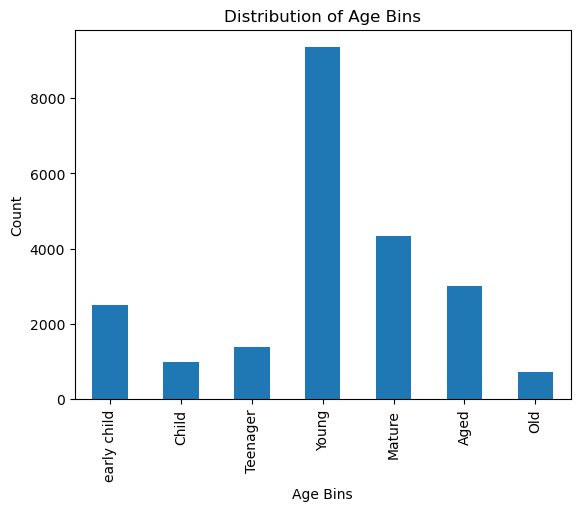

In [9]:
#df['image_array'] = df['image_array'].apply(lambda x:torch.tensor(x))     #Image dataframe to tensors
#Age values  normalised
df['gender'] = df['gender'].astype(int)
df['race'] = df['race'].astype(int)
df['age'] = df['age'].astype(int)
df = df[df['age'] <= 70]
#df['age'] = (df['age'] - df['age'].min()) / (df['age'].max() - df['age'].min())
print(df['age'].describe())

# Define the age bins and labels
bins = [0, 7, 14, 21, 35, 49, 63,70]
labels = ['early child', 'Child', 'Teenager', 'Young', 'Mature', 'Aged', 'Old']

#Mapping Dictionary mapping age bin labels to indices
age_bin_to_index = {'early child': 0, 'Child': 1, 'Teenager': 2, 'Young': 3, 'Mature': 4, 'Aged': 5, 'Old': 6}

# Create a new column 'age_bin' for the age bins
df['age_bin'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

df['age_bin'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Age Bins')
plt.ylabel('Count')
plt.xlabel('Age Bins')
plt.show()

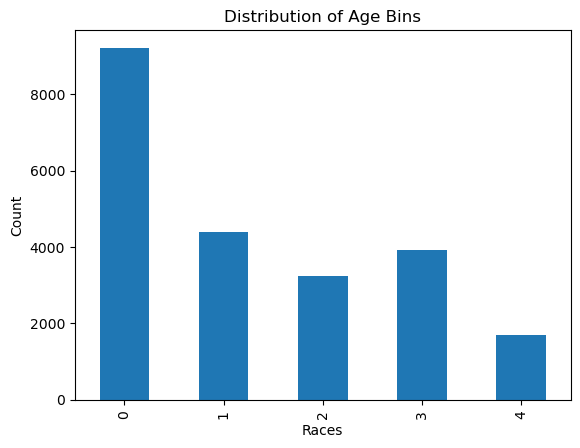

In [10]:
df['race'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Age Bins')
plt.ylabel('Count')
plt.xlabel('Races')
plt.show()

In [11]:
print(df['age_bin'].value_counts())


Young          9350
Mature         4343
Aged           3023
early child    2494
Teenager       1383
Child          1000
Old             739
Name: age_bin, dtype: int64


In [12]:
print(df['gender'].value_counts())
print(df['race'].value_counts())

0    11785
1    10694
Name: gender, dtype: int64
0    9220
1    4398
3    3921
2    3254
4    1686
Name: race, dtype: int64


In [14]:
print("hello world")

hello world


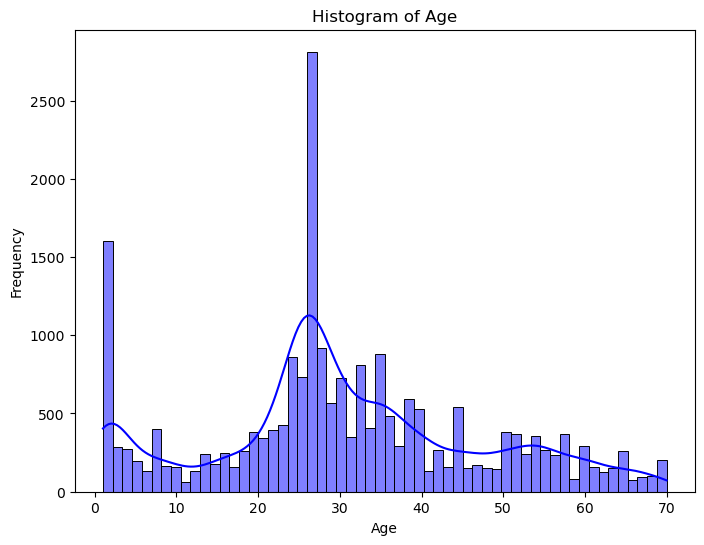

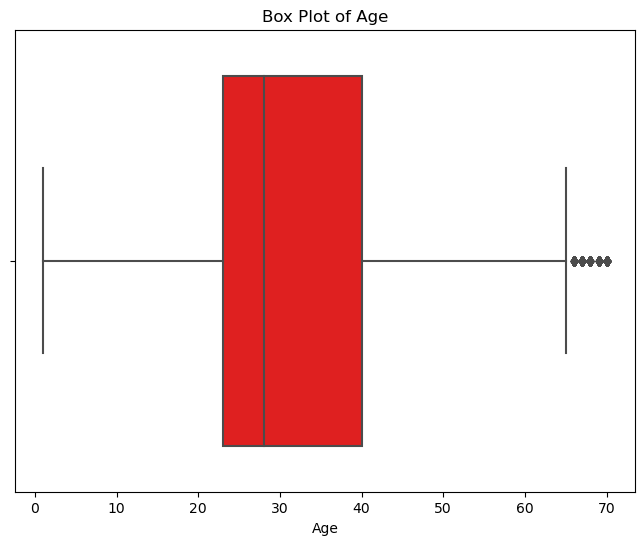

In [13]:
# Plot histogram
plt.figure(figsize=(8, 6))
sns.histplot(df['age'], kde=True, color='blue')
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# Plot box plot
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['age'], color='red')
plt.title('Box Plot of Age')
plt.xlabel('Age')
plt.show()

In [16]:
#df['image_array'] = df['image_array'].apply(lambda x:torch.tensor(x))     #Image dataframe to tensors

#Age values  normalised
#df['age'] = df['age'].astype(float)
#df['age'] = (df['age'] - df['age'].min()) / (df['age'].max() - df['age'].min())



#Creating a custom dataset for the model
class CustomDataset(Dataset):
    def __init__(self,dataframe, transform=None): #Init fn 
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self): #len
        return len(self.dataframe)
    
    def __getitem__(self, idx):                                 #Accessing each item from the dataframe
        
        image = self.dataframe.iloc[idx]['image_array']
        #age = self.dataframe.iloc[idx]['age']
        age_bin = self.dataframe.iloc[idx]['age_bin']
        print(idx)
        print(age_bin)
        if not isinstance(age_bin, str):
            if math.isnan(age_bin):
               return None  
        age_bin_to_index = {'early child': 0, 'Child': 1, 'Teenager': 2, 'Young': 3, 'Mature': 4, 'Aged': 5, 'Old': 6}
        age_index = age_bin_to_index[age_bin]
        gender = self.dataframe.iloc[idx]['gender']
        race = self.dataframe.iloc[idx]['race']
        
        # Convert the image to float32 and normalize its values to [0, 1]
        image = Image.fromarray(image.astype('uint8'))

        if self.transform:
            image = self.transform(image)

        return image, age_index, gender, race

transform = transforms.Compose([
    ToTensor(), 
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


df.sort_index()
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)#Splitting dataframe into Training and Testing set
train_df = train_df.reset_index()
test_df = test_df.reset_index()

train_dataset = CustomDataset(dataframe=train_df, transform=transform) #dataset objects for train and test
test_dataset = CustomDataset(dataframe=test_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=12, shuffle=True) #DataLoader opening the Dataset objects
test_loader = DataLoader(test_dataset, batch_size=12, shuffle=False) 
#Consider Validation on every iteration


In [50]:
print(len(train_dataset))

17983


In [36]:
print(len(test_dataset))

4496


In [37]:
print(len(df))

22479


In [38]:
ibo = CustomDataset(df)

In [54]:
print(ibo[500])

500
early child
(<PIL.Image.Image image mode=RGB size=200x200 at 0x780F6E81E650>, 0, 0, 2)


In [39]:
print(ibo.__getitem__)

<bound method CustomDataset.__getitem__ of <__main__.CustomDataset object at 0x780f6e81c0a0>>


In [28]:
image, age_index, gender, race = ibo[0]

0
Young


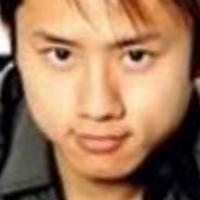

In [29]:
image

In [30]:
age_index

3

In [31]:
gender

0

In [32]:
race

2

In [40]:
image, age_index, gender, race = ibo[1]

1
Young


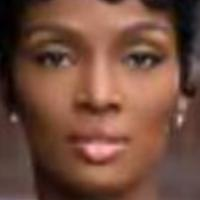

In [42]:
image

In [44]:
age_index

3

In [45]:
gender

1

In [46]:
race

1

In [ ]:
class MultiTaskMobileNet(nn.Module):
    
    def __init__(self):
        super(MultiTaskMobileNet, self).__init__()
        
        self.base_model = models.mobilenet_v2(pretrained=True).features
        
        #Age head
        self.age_head = nn.Sequential(
            nn.Linear(1280, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512,7)
        )
        
        #Gender head
        self.gender_head = nn.Sequential(
            nn.Linear(1280, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512,2)
        )
        
        #Race head
        self.race_head = nn.Sequential(
            nn.Linear(1280, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512,5)
        )
   
    def forward(self,x):
        x = self.base_model(x)
        x = x.mean([2,3])
        
        age = self.age_head(x)
        gender = self.gender_head(x)
        race = self.race_head(x)
        
        return age, gender, race
    
model = MultiTaskMobileNet().cuda()
        
        

In [ ]:
num_epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, age_index, genders, races in train_loader:
        images, age_index, genders, races = images.cuda(), age_index.cuda(), genders.cuda(), races.cuda()

        optimizer.zero_grad()

        age_outputs, gender_outputs, race_outputs = model(images)

        loss1 = criterion(age_outputs, age_index)
        loss2 = criterion(gender_outputs, genders)
        loss3 = criterion(race_outputs, races)
        
        loss = loss1 + loss2 + loss3

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{num_epochs}] Loss: {running_loss/len(train_loader)}")

In [ ]:
#print(df.iloc[1130])
print(train_df.iloc[14577]['age_bin'])

In [ ]:
# Plot histogram
plt.figure(figsize=(8, 6))
sns.histplot(df['age'], kde=True, color='blue')
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# Plot box plot
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['age'], color='red')
plt.title('Box Plot of Age')
plt.xlabel('Age')
plt.show()

In [ ]:
df['age_transformed'] = np.log1p(df['age'])
plt.figure(figsize = (8,6))
sns.histplot(df['age_transformed'], kde=True)
plt.title('Log Transformed Age Distribution')
plt.xlabel('Log-Age')
plt.ylabel('Frequency')
plt.show()